In [1]:
import polars as pl
import numpy as np
import os, re, math
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import dataclasses
import scipy.stats

In [2]:
%config InlineBackend.figure_formats = ['png']
plt.rcParams["figure.figsize"] = (10, 6)
def show():
    os.makedirs("plots", exist_ok=True)
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".pdf")
    plt.show()


In [3]:
df = pl.read_parquet("/home/exyi/mount/random_skrina_d/test/pymol-vids/tables/cWW-G-C-filtered.parquet")

is_dna = pl.col("res1").str.starts_with("D") | pl.col("res2").str.starts_with("D")
is_rna = pl.col("res1").str.starts_with("D").is_not() | pl.col("res2").str.starts_with("D").is_not()

print(df.schema)
df.sum()

def running_stat(f):
    resolutions = np.arange(1.2, 3.5, 0.1)
    results = []
    for resolution in resolutions:
        results.append({
            "resolution": resolution,
            "value": f(df.filter((pl.col("resolution") < resolution) & (pl.col("resolution") >= resolution - 0.6)))
        })
    return pl.DataFrame(results)

legend = []
def get_spread(s: pl.DataFrame, relative_to: float):
    max_spread = s["value"].max() - s["value"].min()
    a2_spread = s.filter(pl.col("resolution") < 1.8).sort("resolution", descending=True)["value"][0] - s.sort("resolution", descending=True)["value"][0]

    return {
        "max_spread": max_spread / relative_to,
        "a18_spread": a2_spread / relative_to
    }

def plot_running_stat(f: typing.Callable[[pl.DataFrame], typing.Any], column: str, label: str):
    s = running_stat(f)
    plt.plot(s["value"].to_numpy(), s["resolution"].to_numpy())
    spread = get_spread(s, relative_to=1)
    legend.append(f"{label} {spread['max_spread']:.4f} {spread['a18_spread']:.4f}")
def sample_for_kde(x: np.ndarray, threshold = 5_000):
    if len(x) <= threshold:
        return x
    else:
        return np.random.choice(x, threshold, replace=False)

def mode(arr, bw_factor = 1) -> float:
    if len(arr) < 5:
        return np.mean(arr)

    kde = scipy.stats.gaussian_kde(sample_for_kde(arr))
    kde.set_bandwidth(lambda _: kde.scotts_factor() * bw_factor)
    mode = np.argmax(kde.pdf(arr))
    return arr[mode]

OrderedDict([('pdbid', String), ('model', Int64), ('chain1', String), ('chain2', String), ('res1', String), ('res2', String), ('nr1', Int64), ('nr2', Int64), ('alt1', String), ('alt2', String), ('ins1', String), ('ins2', String), ('symmetry_operation', String), ('type', String), ('hb_0_length', Float64), ('hb_0_donor_angle', Float64), ('hb_0_acceptor_angle', Float64), ('hb_1_length', Float64), ('hb_1_donor_angle', Float64), ('hb_1_acceptor_angle', Float64), ('hb_2_length', Float64), ('hb_2_donor_angle', Float64), ('hb_2_acceptor_angle', Float64), ('hb_3_length', Float64), ('hb_3_donor_angle', Float64), ('hb_3_acceptor_angle', Float64), ('bogopropeller', Float64), ('deposition_date', String), ('structure_name', String), ('structure_method', String), ('resolution', Float32), ('pair_bases', String), ('label', String), ('jirka_approves', Boolean), ('mode_deviations', Float64), ('log_likelihood', Float64)])


/tmp/ipykernel_72649/1079432651.py:4: DeprecationWarning: `is_not` is deprecated. It has been renamed to `not_`.
  is_rna = pl.col("res1").str.starts_with("D").is_not() | pl.col("res2").str.starts_with("D").is_not()


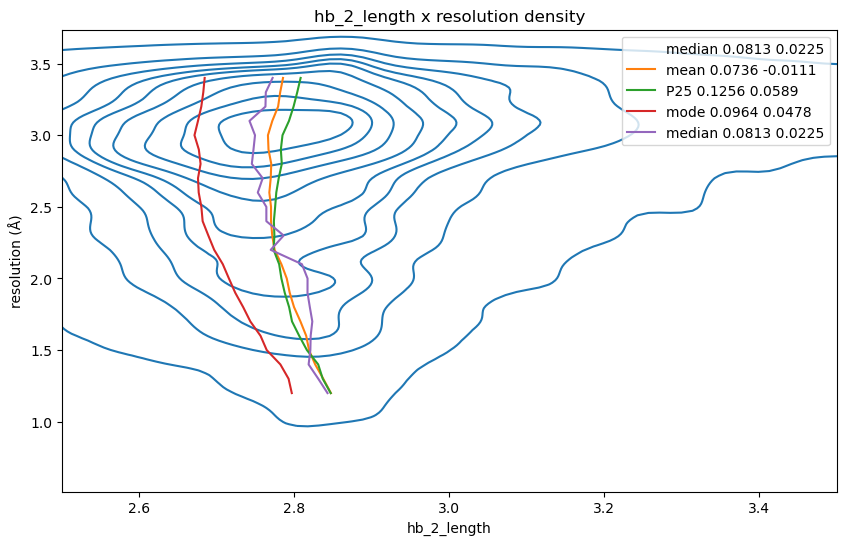

In [8]:

column = "hb_2_length"
sns.kdeplot(df, thresh=0.02, x=column, y="resolution").set(title=f"{column} x resolution density", ylabel="resolution (Å)")
plot_running_stat(lambda df: float(df[column].median()), column, "median")
plot_running_stat(lambda df: float(df[column].mean()), column, "mean")
plot_running_stat(lambda df: float(df[column].quantile(0.25)), column, "P25")
plot_running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy())), column, "mode")
plt.legend(legend)
plt.xlim(2.5, 3.5)
show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_donor_angle", y="resolution").set(title="cWW CG pair H-Bond donor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_acceptor_angle", y="resolution").set(title="cWW CG pair H-Bond acceptor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_length", y="resolution").set(title="cWW CG pair H-Bond length", xlabel="N1 · · · N3 H-bond length (Å)", ylabel="resolution (Å)")
# show()


Best quantile: shape: (1, 4)
┌──────────┬─────────────┬─────────────┬─────────────┐
│ quantile ┆ hb_0_length ┆ hb_1_length ┆ hb_2_length │
│ ---      ┆ ---         ┆ ---         ┆ ---         │
│ f64      ┆ f64         ┆ f64         ┆ f64         │
╞══════════╪═════════════╪═════════════╪═════════════╡
│ 0.45     ┆ -0.127479   ┆ -0.053816   ┆ 0.144968    │
└──────────┴─────────────┴─────────────┴─────────────┘
Mode: {'hb_0_length': -0.027917195449046372, 'hb_1_length': -0.005846566777208878, 'hb_2_length': 0.25989286799213873}


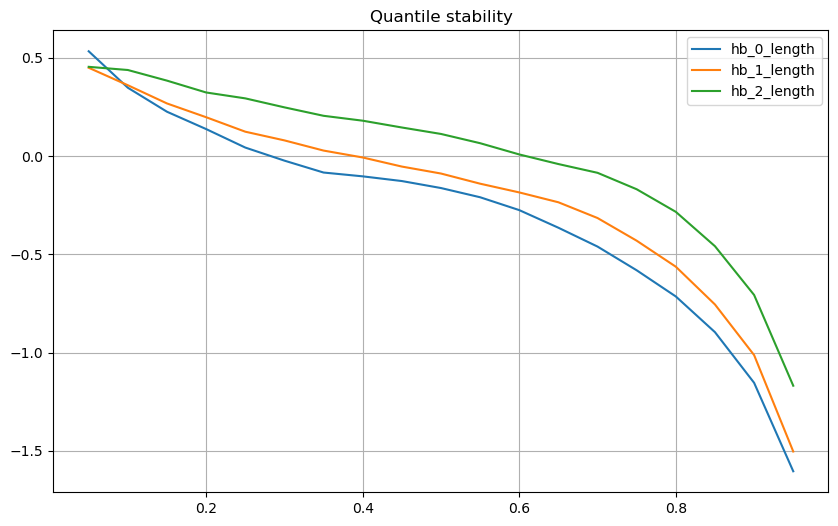

In [5]:
# columns = [ "hb_0_length", "hb_1_length", "hb_2_length", "hb_0_donor_angle", "hb_1_donor_angle", "hb_2_donor_angle", "hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle" ]
columns = [ "hb_0_length", "hb_1_length", "hb_2_length" ]
data = []
plt.title("Quantile stability")
for quantile in np.arange(0.05, 1, 0.05):
    row = { "quantile": quantile }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(df[column].quantile(quantile))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["quantile"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.legend(columns)
best_quantile = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))[0]
print(f"Best quantile: {best_quantile}")
m = {
    col: get_spread(running_stat(lambda df: float(mode(df[col].drop_nulls().to_numpy()))), relative_to=df[col].std())["a18_spread"]
    for col in columns
}
print(f"Mode: {m}")
show()

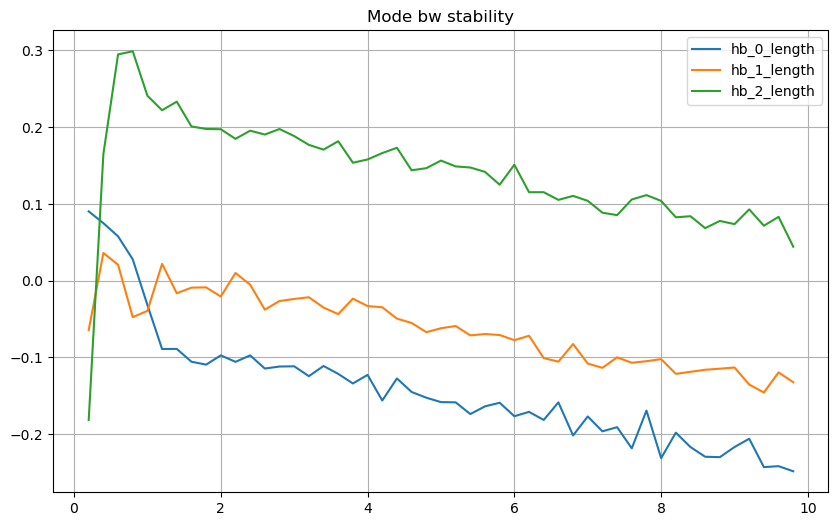

Best bw: 0.4


In [6]:
plt.title("Mode bw stability")
data = []
for bw_factor in np.arange(0.2, 10, 0.2):
    row = { "bw_factor": bw_factor }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy(), bw_factor))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["bw_factor"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.legend(columns)
show()
best_bw = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))["bw_factor"][0]
print(f"Best bw: {best_bw}")

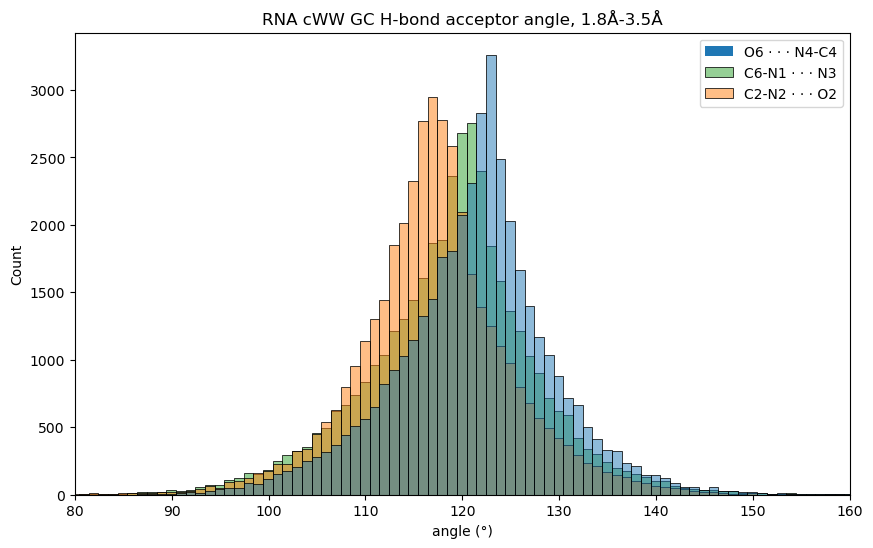

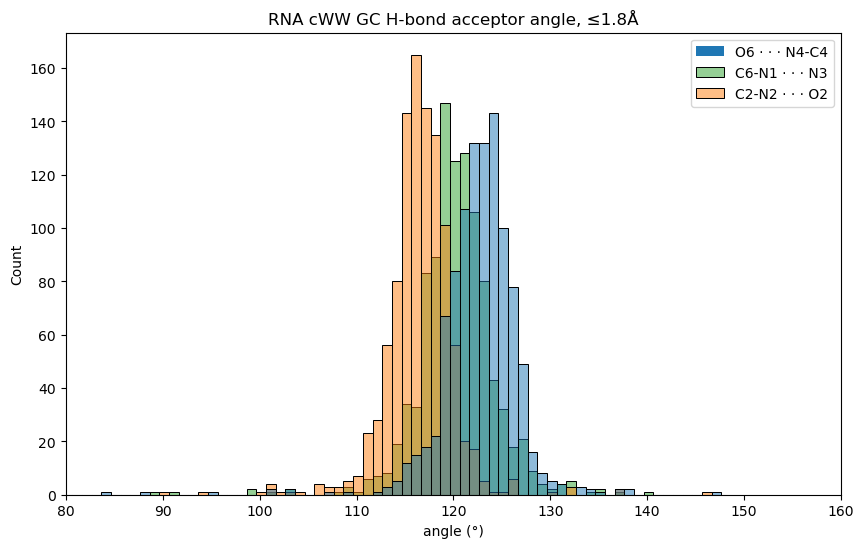

In [14]:
sns.histplot(data=data.filter(is_med_quality & is_rna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW GC H-bond acceptor angle, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()
sns.histplot(data=data.filter(is_high_quality & is_rna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW GC H-bond acceptor angle, ≤1.8Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()


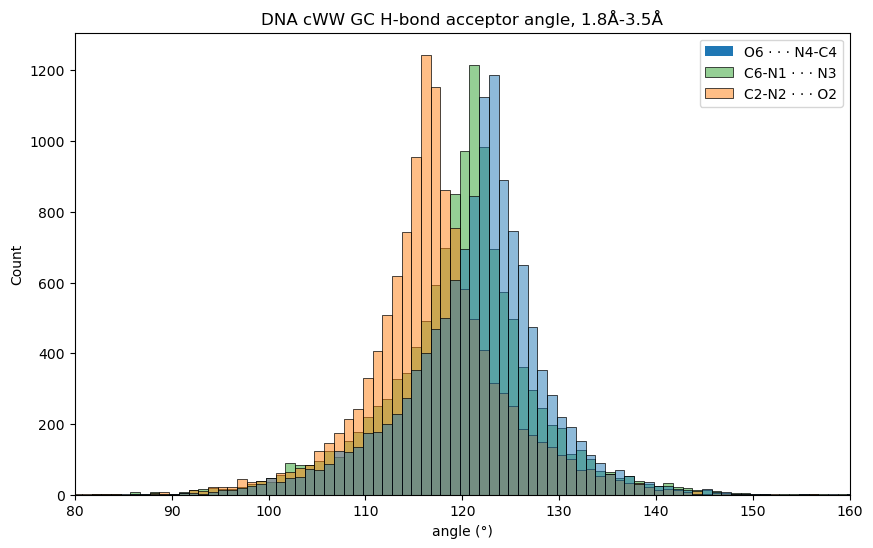

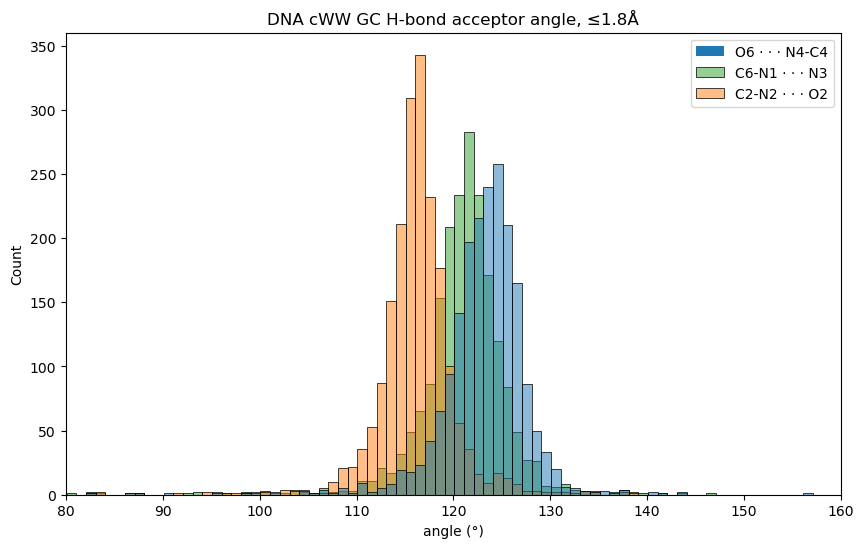

In [15]:
sns.histplot(data=data.filter(is_med_quality & is_dna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW GC H-bond acceptor angle, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()
sns.histplot(data=data.filter(is_high_quality & is_dna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW GC H-bond acceptor angle, ≤1.8Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()


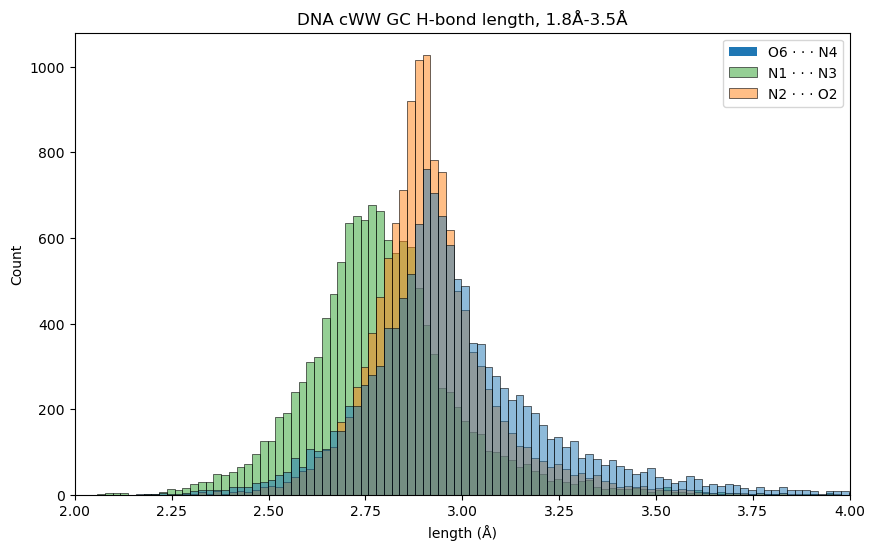

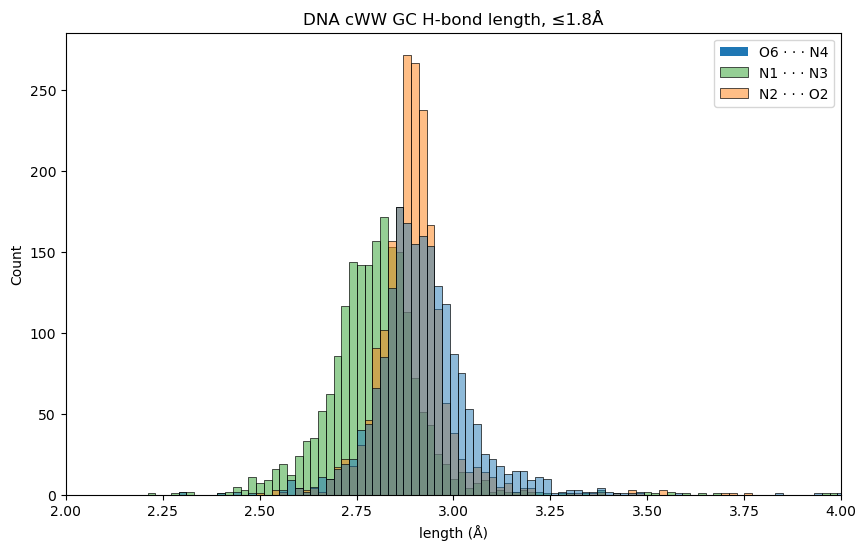

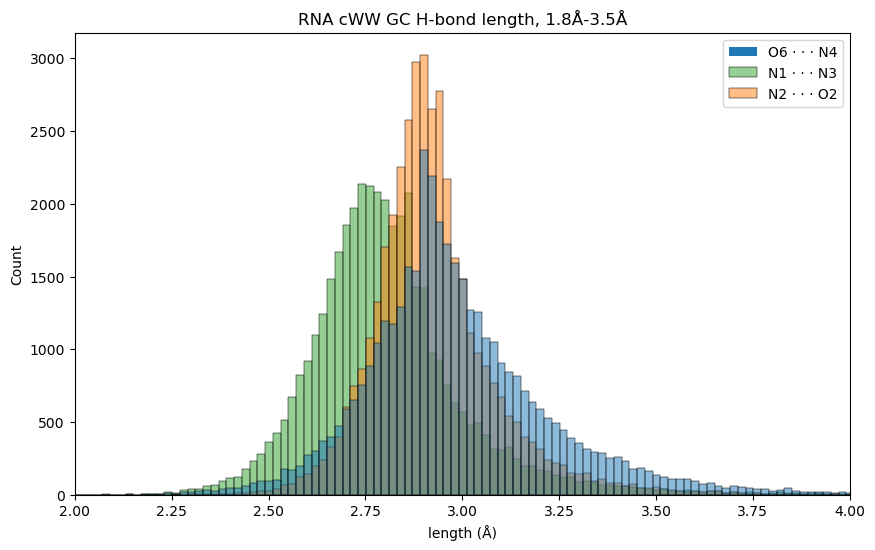

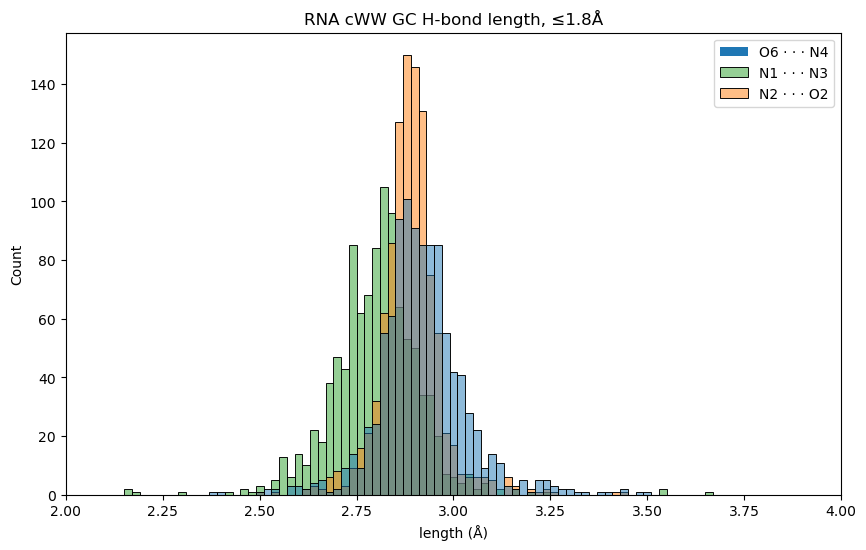

In [82]:
sns.histplot(data=data.filter(is_med_quality & is_dna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW GC H-bond length, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_high_quality & is_dna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW GC H-bond length, ≤1.8Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_med_quality & is_rna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW GC H-bond length, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_high_quality & is_rna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW GC H-bond length, ≤1.8Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()


In [19]:
audata = load_pair_table("/home/exyi/tmp/basepaircsv/cWW-AU-bothangles.csv.parquet")


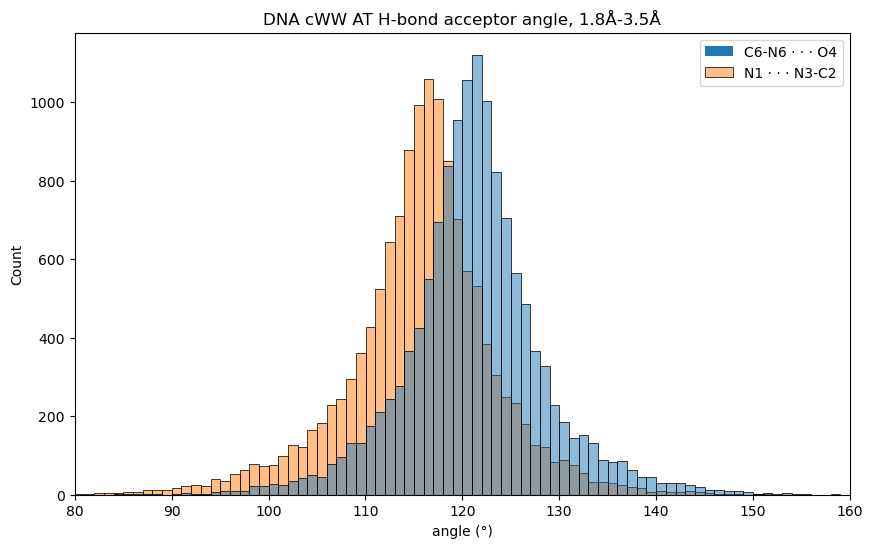

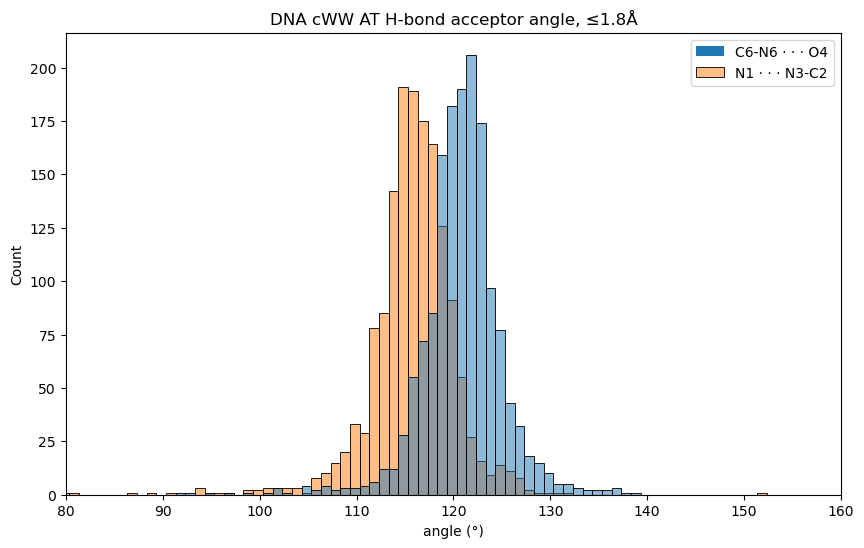

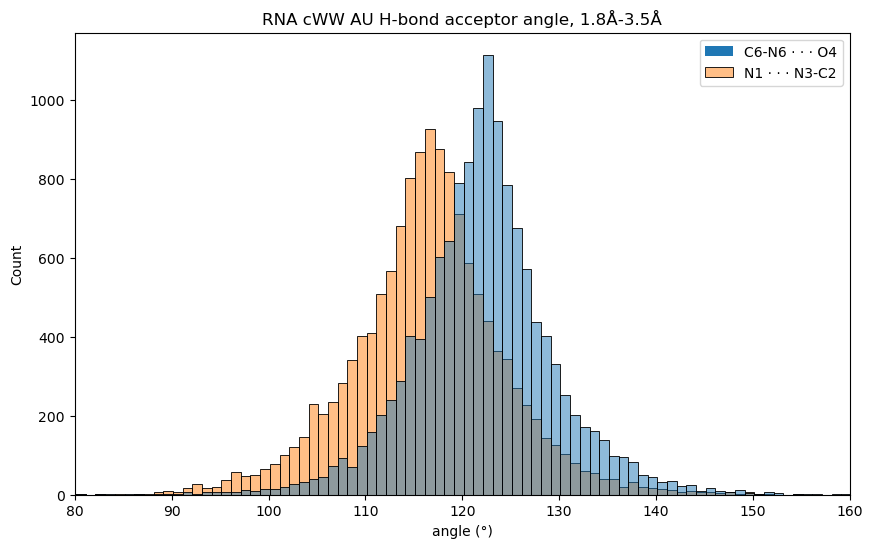

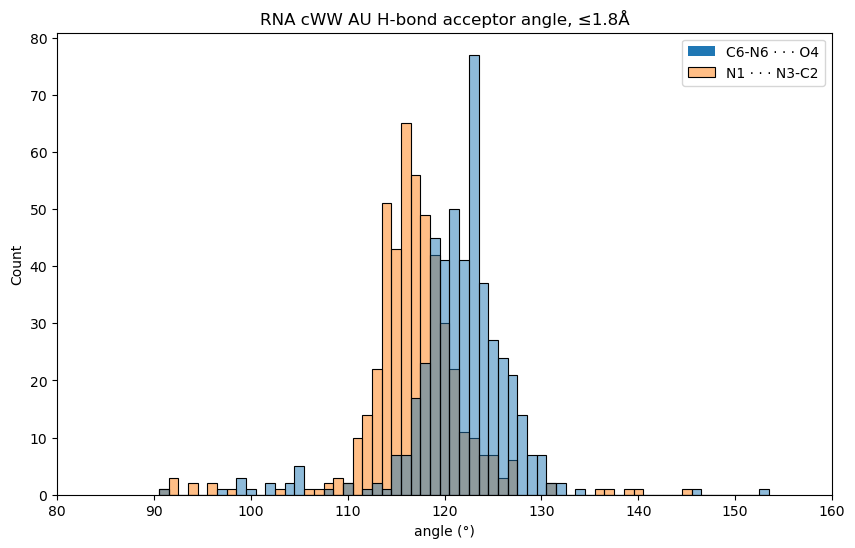

In [20]:
sns.histplot(data=audata.filter(is_med_quality & is_dna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW AT H-bond acceptor angle, 1.8Å-3.5Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_high_quality & is_dna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW AT H-bond acceptor angle, ≤1.8Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_med_quality & is_rna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW AU H-bond acceptor angle, 1.8Å-3.5Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_high_quality & is_rna)[["hb_0_acceptor_angle", "hb_1_acceptor_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW AU H-bond acceptor angle, ≤1.8Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()


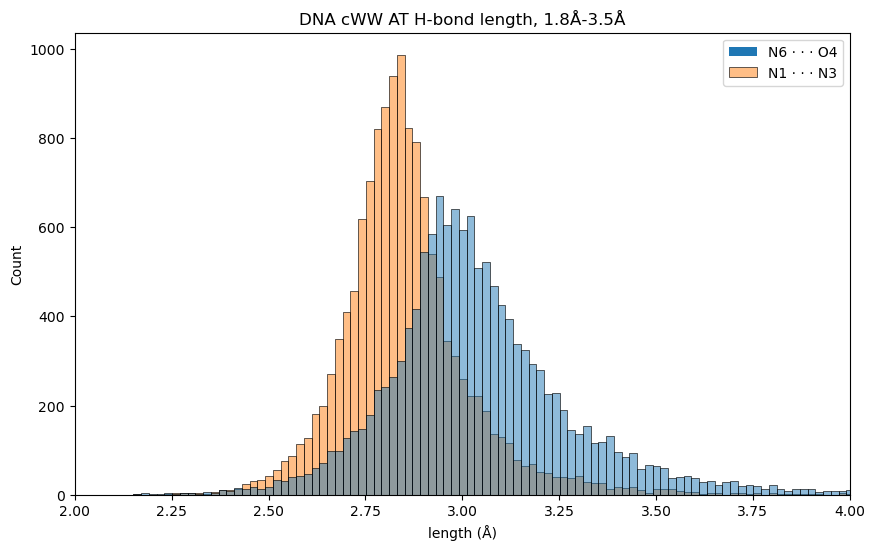

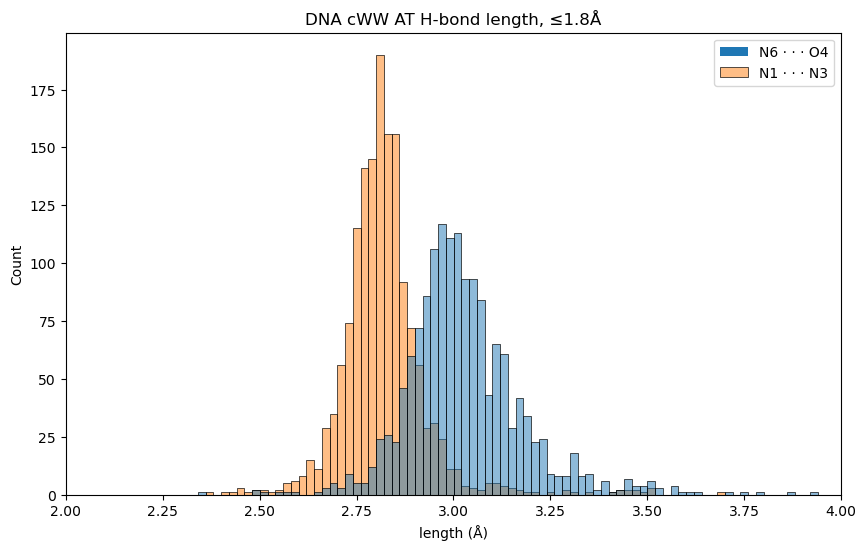

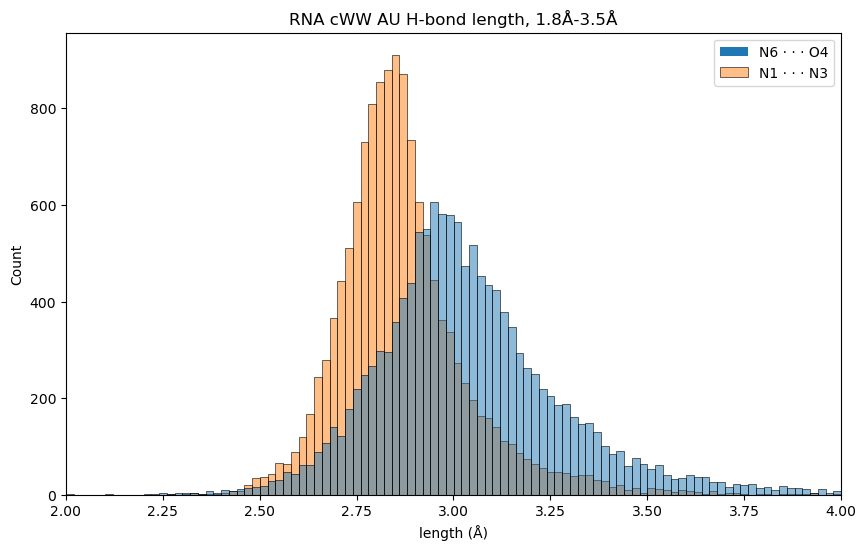

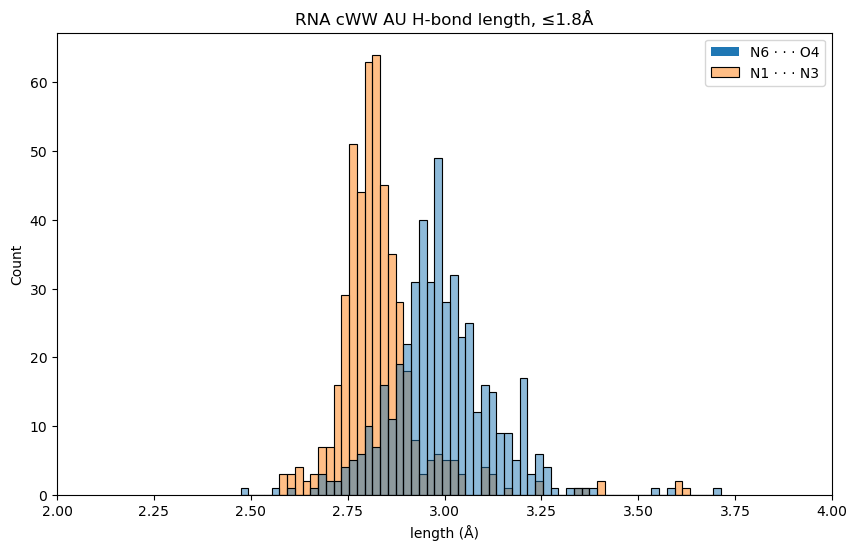

In [86]:
sns.histplot(data=audata.filter(is_med_quality & is_dna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW AT H-bond length, 1.8Å-3.5Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_high_quality & is_dna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW AT H-bond length, ≤1.8Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_med_quality & is_rna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW AU H-bond length, 1.8Å-3.5Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_high_quality & is_rna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW AU H-bond length, ≤1.8Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
